# Multi Class Threat Classifier:
- Run the best SMOTE Model.
- Pass the predicted labels which contain all threats and some Normal labels to the secondary multi-class Tree Model.
- Evaluate Results for the predictions in the Tree Model.
- Evaluate the Results in SHAP by comparing the correctly and incorrectly predicted labels for DoS.

Standard imports. Many imports are handled by importing the Models and Tools.

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics, accuracy_score
import shap
from Tools.shap_manager import SHAPmanager

Here we load the previously collected one hot encoded features which gives us a total of 322 features and 2 target variables.

In [8]:
data = pd.read_csv('Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')
data2 = data.copy()
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

C:\Users\adi_s\AppData\Local\Temp\ipykernel_7224\2287905068.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


Now we label encode the features and target multi-class label for the Tree Model. The feature encoder is stored in a list so it can be inverse transformed in the SHAP manager class.

In [9]:
# Label encode the features and store in a list.
cols = ['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip']
data2[cols] = data2[cols].astype(str)
le_features = []
for c in cols:
    le = LabelEncoder()
    data2[c] = le.fit_transform(data2[c])
    le_features.append(le)
le_label = LabelEncoder()
data2['attack_cat'] = le_label.fit_transform(data2['attack_cat'].astype(str))

Split the data for training and testing for the Tree Model.

In [4]:
# Make an additional replica dataset using the same split for the tree model.
y2 = data2['attack_cat']
temp2 = data2.drop(columns=['label', 'attack_cat'])
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    temp2, y2, test_size=0.2, random_state=42)
print('Train:', y_train2.value_counts())
print('Test', y_test2.value_counts())
print(len(X_test2))

Train: attack_cat
6    1774933
5     172371
3      35793
4      19462
2      13038
7      11137
0       2127
1       1852
8       1191
9        133
Name: count, dtype: int64
Test attack_cat
6    443831
5     43110
3      8732
4      4784
2      3315
7      2850
0       550
1       477
8       320
9        41
Name: count, dtype: int64
508010


Here we split the data for the NN Model using the same random seeds.

In [10]:
# First remove the labels in the actual data.
temp1 = data.drop(columns=['label', 'attack_cat'])
# Set y1 as the binary label.
y1 = data['label']
# Split the data into 80% train and 20% test.
X_train, X_test, y_train, y_test = train_test_split(
    temp1, y1, test_size=0.2, random_state=42)
print(len(X_test))
print(len(X_test2))

508010
508010


The Neural Network requires tensors. They are passed into a DataLoader object which handles the batching.

In [11]:
# Select the batch size. This directly impacts the effectiveness of some sampling methods.
batch_size = 128
# Convert each train and test set into tensors.
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
# Convert to a Tensor Dataset which stores both the train and test sets.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Add the Tensor Datasets into a DataLoader object which manages the batching. Shuffle function is used on the train set but not the test set.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We load the best SMOTE model and run it on the test set.

c:\Users\adi_s\Desktop\LSTM\Models\models.py:262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))
Testing: 100%|██████████| 3969/3969 [0

Test Loss: 0.0205, Test Accuracy: 0.9877, Test F1: 0.9881


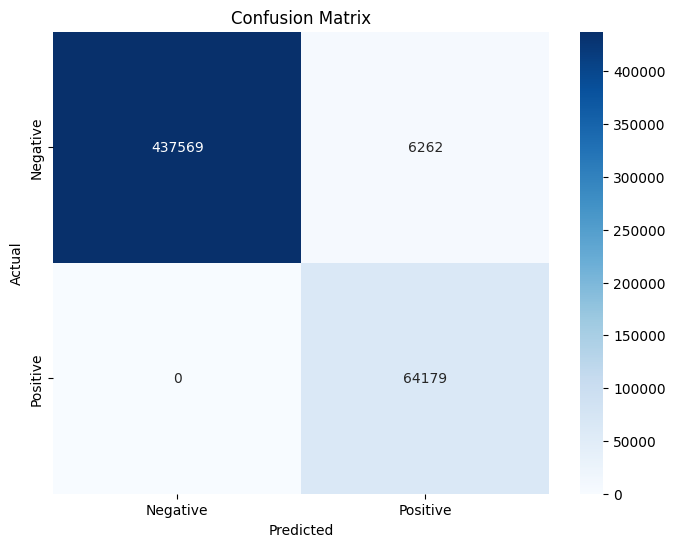

In [12]:
# Import the Neural Network and supporting functions.
from Models.models import NNdynamic, plot_metrics, plot_confusion_matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 256
save_dir = './Models/saved_models/'
model = NNdynamic(n_features, fc_size, device, save_dir)
model.load_model('./Models/saved_models/02/smote/01-256/PB_epoch_5.pth')
model.test(test_loader)
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model.test_predicted)

Here we use XGBoost as the Random Forest can cause the kernel to crash during the calculation of shap values for multi-class labels.

In [13]:
import xgboost as xgb
model2 = xgb.XGBClassifier()
model2.fit(X_train2, y_train2)
# This ommits an error in XGBoost. - Not sure why it happens..
# Attribute doesn't exist error (__setattribute__) - something like that.
print()

Now we take the predicted labels for threats and create a new test set for the multi-class Tree Model. All threats that are predicted along with false predictions on Normal labels are passed over.

In [14]:
X_test2['pred'] = model.test_predicted
X_test2['actual'] = y_test2
X_test2 = X_test2[X_test2['pred'] == 1]
X_test2 = X_test2.reset_index(drop=True)
y_test2 = X_test2['actual']
X_test2 = X_test2.drop(columns=['pred', 'actual'])

In [15]:
y_pred = model2.predict(X_test2)

We evaluate the predictions. Using the mappings below we can see that a lot of the DoS false predictions are due to the model misclassifying it as another threat.

In [16]:
print(confusion_matrix(y_test2, y_pred))

[[   37     0   112   300    33     2    66     0     0     0]
 [    0    37   112   282    37     3     0     4     2     0]
 [    0     1  1011  2175    48    23    21    15    20     1]
 [    0     2   717  7551   100    86    98   142    33     3]
 [    0     0   110   431  2978     5  1257     2     1     0]
 [   13     0   119   380     8 42565     5     6    12     2]
 [    5     2     2    57   765     2  5424     3     2     0]
 [    0     0    93   494     3     0     3  2257     0     0]
 [    0     0     7    25     9     1     4     3   271     0]
 [    0     0     0    23     0     2     0     0     0    16]]


In [17]:
print("Class index to label mapping:")
for i, label in enumerate(le_label.classes_):
    print(f"{i} -> {label}")

Class index to label mapping:
0 -> Analysis
1 -> Backdoor
2 -> DoS
3 -> Exploits
4 -> Fuzzers
5 -> Generic
6 -> Normal
7 -> Reconnaissance
8 -> Shellcode
9 -> Worms


We build the TreeExplainer with the secondary Model. Avoiding background data significantly increases computation time for the sample data.

In [18]:
xp1 = shap.TreeExplainer(model2)

Now we create sample data using the correct and incorrect predictions on DoS.

In [19]:
X_test2['actual'] = y_test2
X_test2['pred'] = y_pred
dos_idx = 2
# Dos Correct and incorrect.
dos_correct = X_test2[(X_test2['actual'] == dos_idx) & (X_test2['pred'] == dos_idx)]
dos_incorrect = X_test2[(X_test2['actual'] == dos_idx) & (X_test2['pred'] != dos_idx)]
dos_correct = dos_correct.drop(columns=['actual', 'pred'])
dos_incorrect = dos_incorrect.drop(columns=['actual', 'pred'])

In [20]:
dos_correct = dos_correct.reset_index(drop=True)
dos_incorrect = dos_incorrect.reset_index(drop=True)

We create an Explainer object which is used in the SHAP manager class.

In [ ]:
# Computation time: 1.2 seconds. TreeExplainer is extremely fast compared to other Explainers.
explainer1 = xp1(dos_correct)
explainer2 = xp1(dos_incorrect)

We set the SHAP manager to multi and include the feature and label encoder. The label is set to DoS to start with.

In [22]:
label_type = 'multi'
set_label = 'DoS'
sm1 = SHAPmanager(explainer1, label_type=label_type, feature_encoder=le_features, label_encoder=le_label, set_label=set_label)
sm2 = SHAPmanager(explainer2, label_type=label_type, feature_encoder=le_features, label_encoder=le_label, set_label=set_label)

The summary plot shows us overall differences between correct and incorrect predictions for DoS. There seem to be some differences in the top 3 features Destination Ports, sttl, and dttl. Some other differences are found in sipkts, djit, sintpkt. There are other variable differences in terms of their actual values.

Correct Predictions


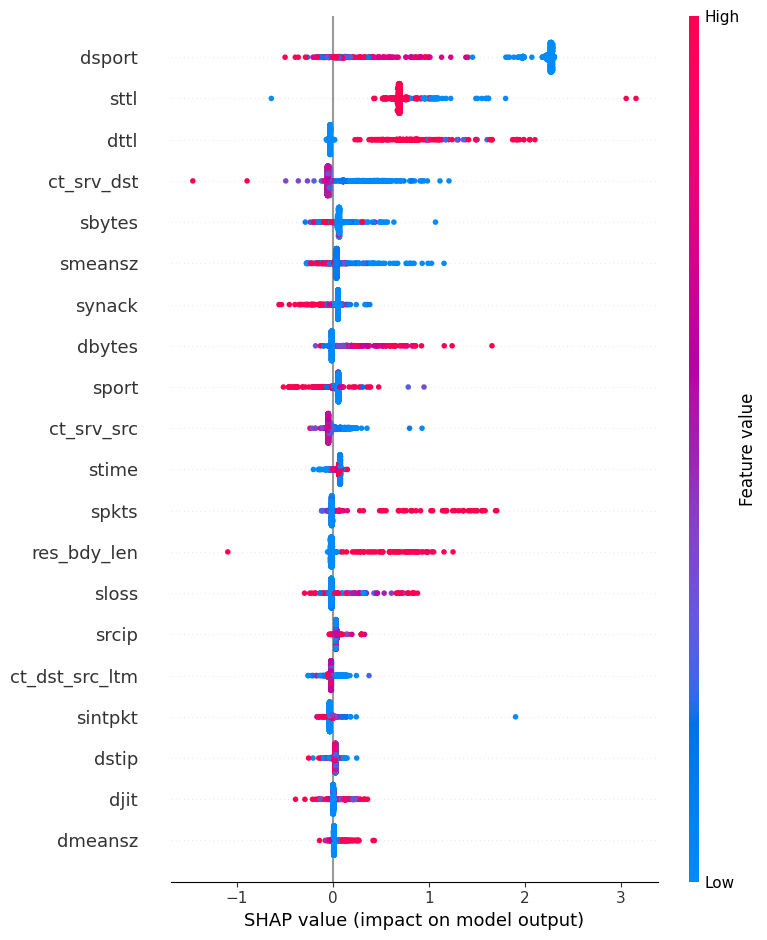

Incorrect Predictions


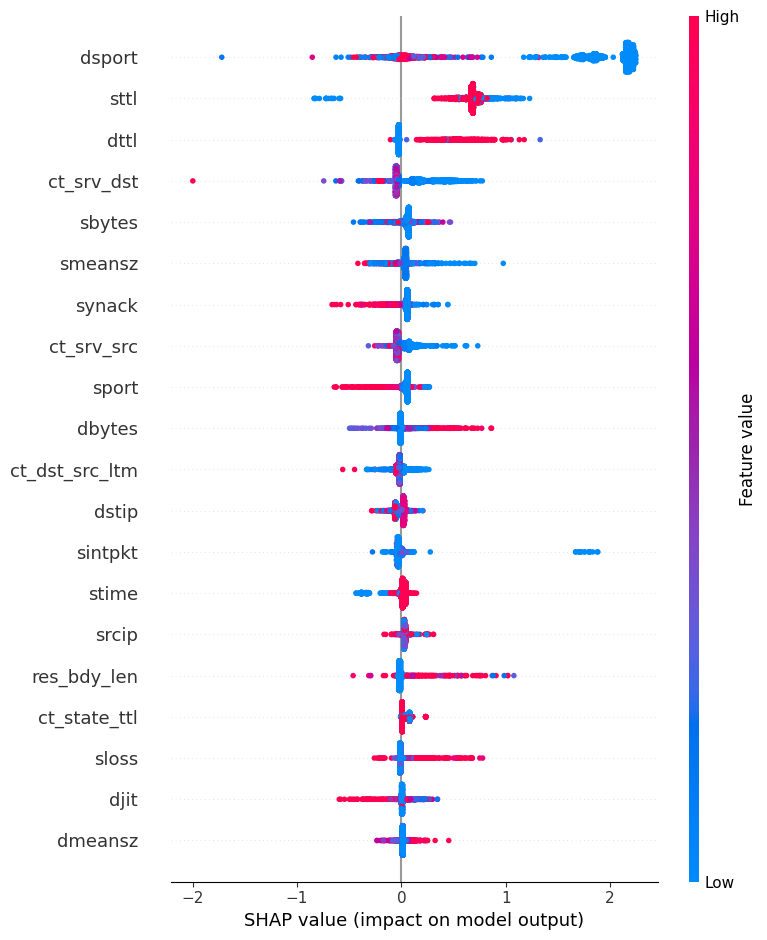

In [23]:
max_features = 20
print('Correct Predictions')
sm1.plot_summary(max_features=max_features)
print('Incorrect Predictions')
sm2.plot_summary(max_features=max_features)

A closer look at some of the differences in features. The biggest differences are definitely in destination port followed by sttl and dttl. Some low values in sintpkt seem to high high importance in incorrect predictions for DoS. There doesnt seem to be large differences in Protocol however, some can be seen in Service and especially State.

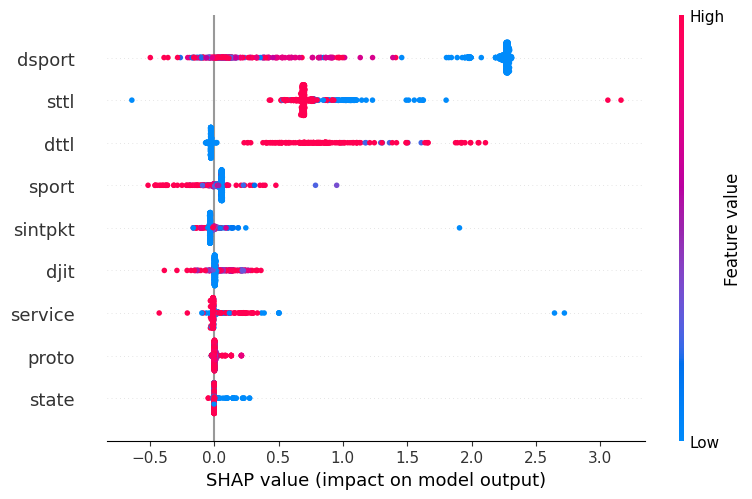

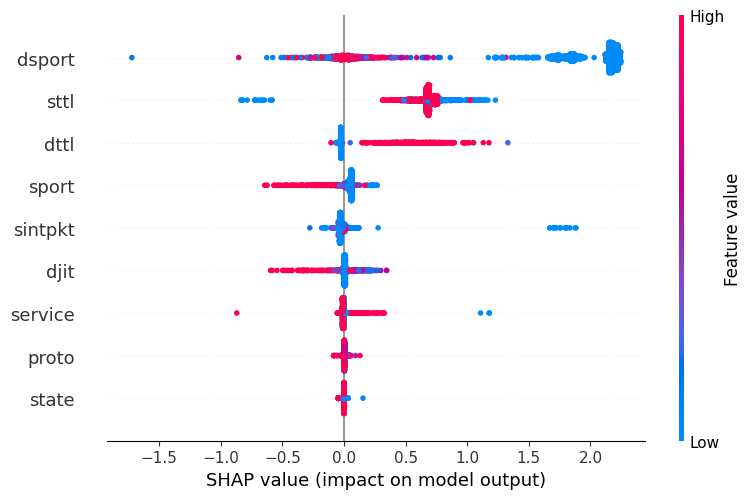

In [27]:
features = ['dsport', 'sport', 'sttl', 'dttl', 'djit', 'sintpkt', 'service', 'state', 'proto']
sm1.plot_summary(features=features)
sm2.plot_summary(features=features)

The correct predictions show that for Destination Ports DoS and Backdoors shared a similar amount of importance whereas Exploits were much lower. However for sttl and Source Ports Exploits where much higher than both. dttl also showed an almost even importance for DoS, Exploits, and Backdoors. In general the plot shows a much lower importance for DoS compared to the rest of the labels. Interestingly we see a similar pattern for incorrect predictions.

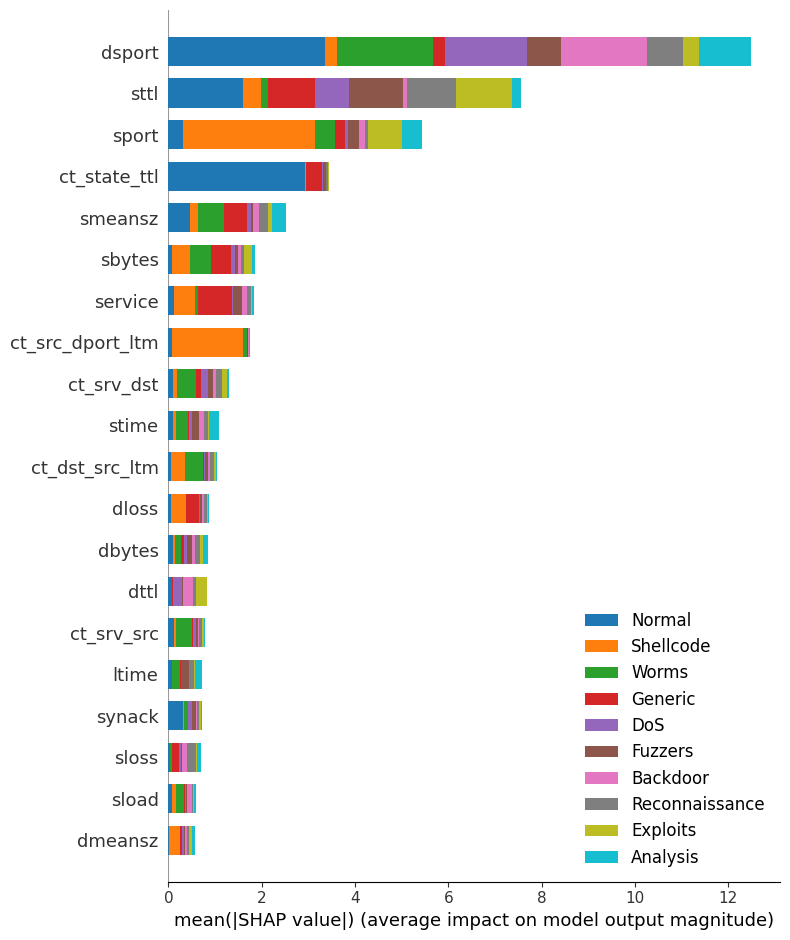

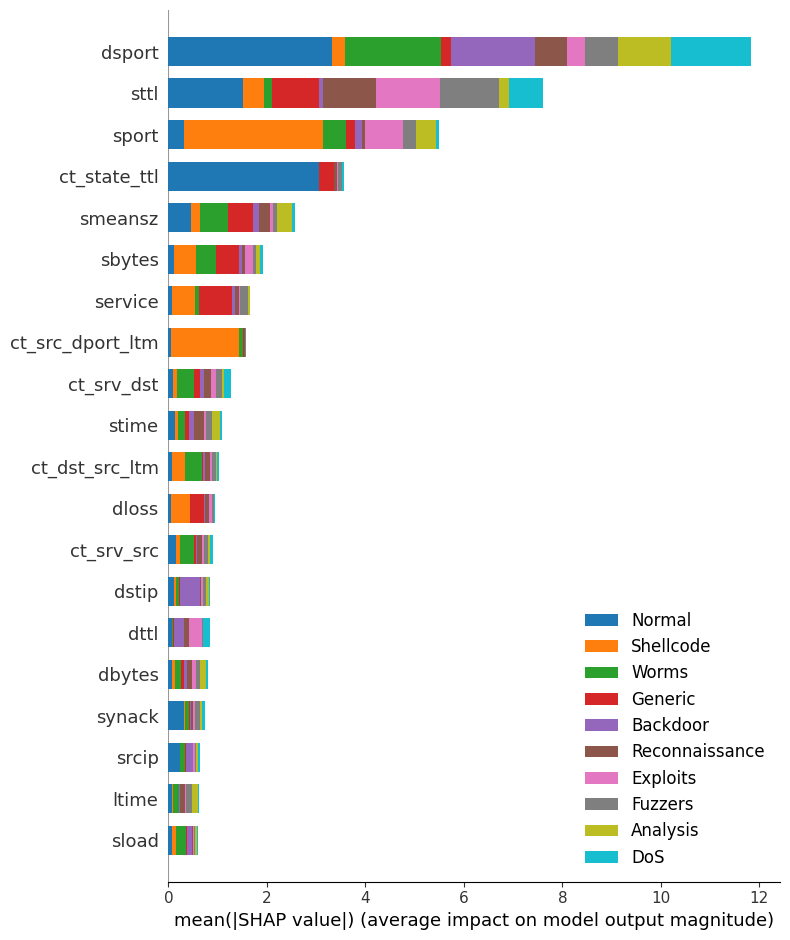

In [28]:
sm1.plot_summary(multi='All')
sm2.plot_summary(multi='All')

In [36]:
sm1.restore_data()
sm2.restore_data()

In [37]:
sm1.string_encode(['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
sm2.string_encode(['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [38]:
type_of = 'label-encoded'
limit = 40
calculation = 'average'
sm1.custom_group('dsport', limit=limit, calculation=calculation)
sm2.custom_group('dsport', limit=limit, calculation=calculation)

The first noticable difference is in Port 0. Port 0 is an automatic feed forward Port where it is assigned automatically during the process. It seems that DoS labels that originate from these Ports contribute highly to false predictions. Other noticeable differences is that high importance for incorrect predictions stem from many of the other ports not shown whereas this is not the case for correct predictions. The strongest interactions for Destination Ports for correct predictions come from stime and ltime where the values vary alot throughout. As for incorrect predictions the highest interactions are sjit and tcprtt where for both their low values interact with Port 0 and rest tend to be higher values.

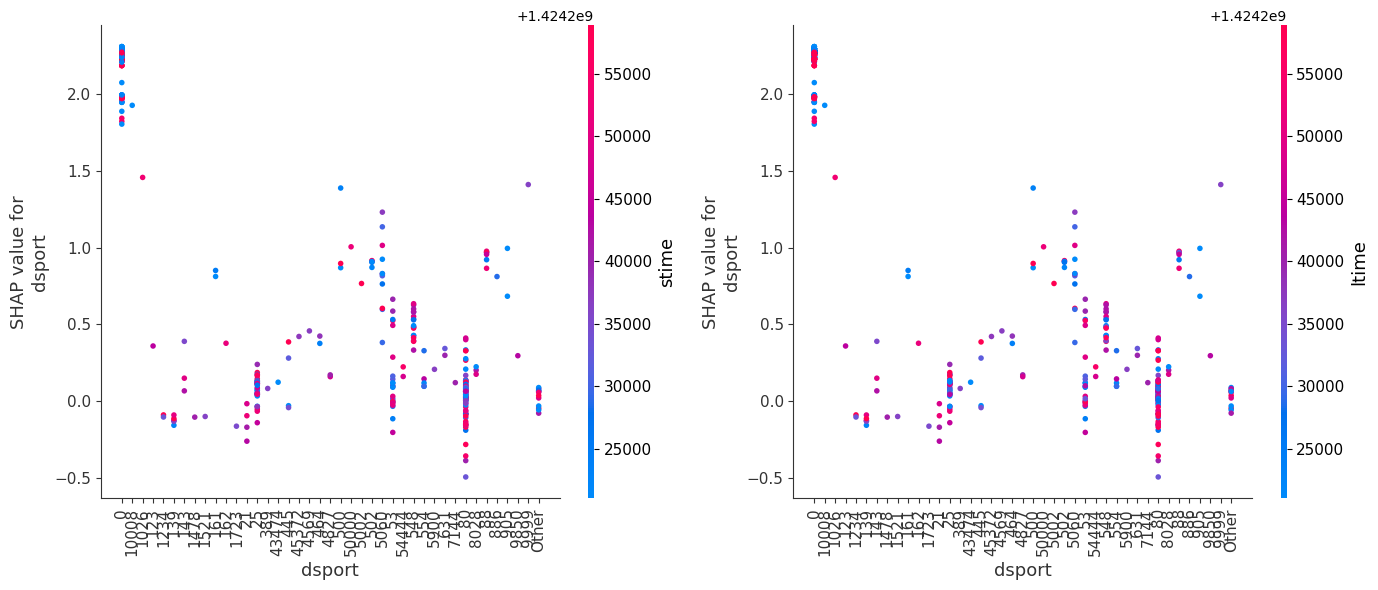

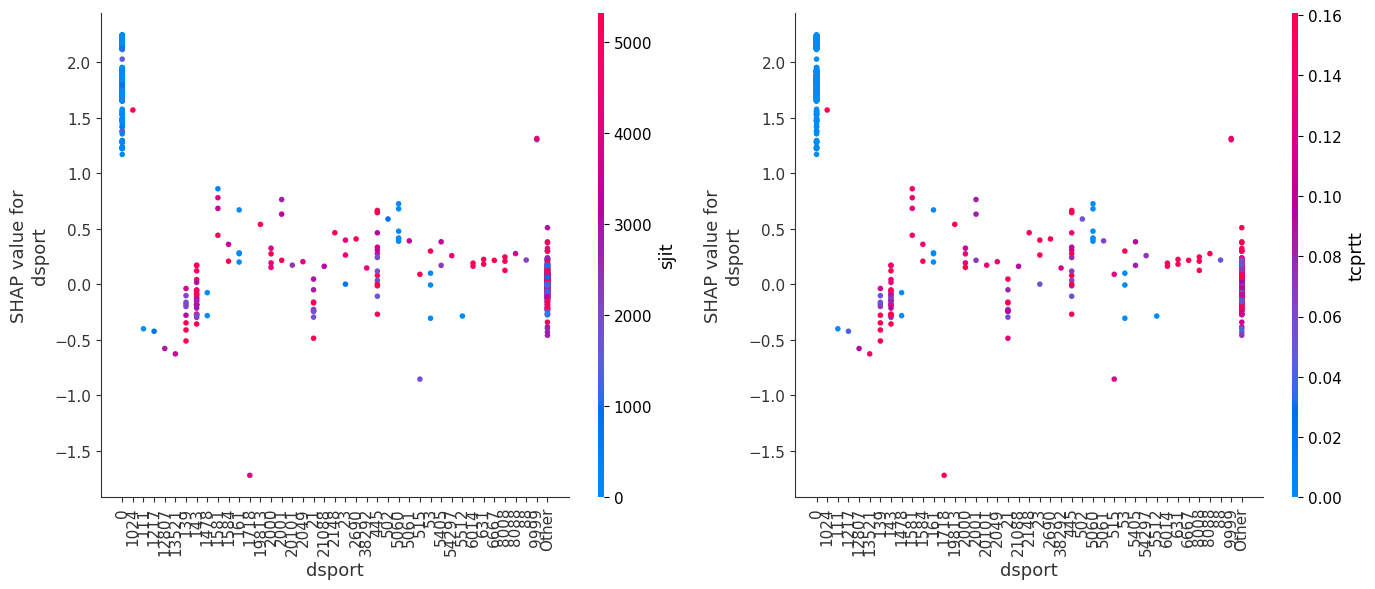

In [39]:
sm1.plot_dependence('dsport', n_interaction=2)
sm2.plot_dependence('dsport', n_interaction=2)

We see a very similar patter to Source Ports except a few differences in the interaction values. For correct predictions stime tends to be higher values for Port 0 whereas ltime is mostly the same. As for the incorrect predictions, the interaction variables are the same and the values corresponding to Port 0 are very similar.

In [40]:
type_of = 'label-encoded'
limit = 40
calculation = 'average'
sm1.custom_group('sport', limit=limit, calculation=calculation)
sm2.custom_group('sport', limit=limit, calculation=calculation)

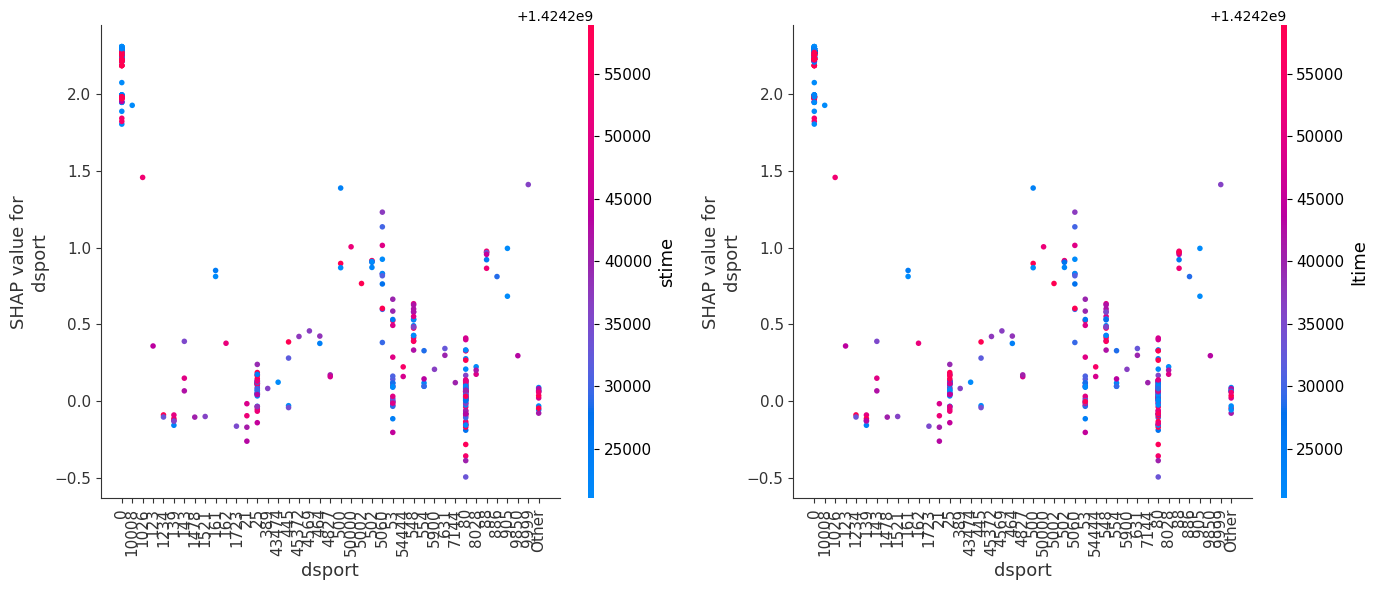

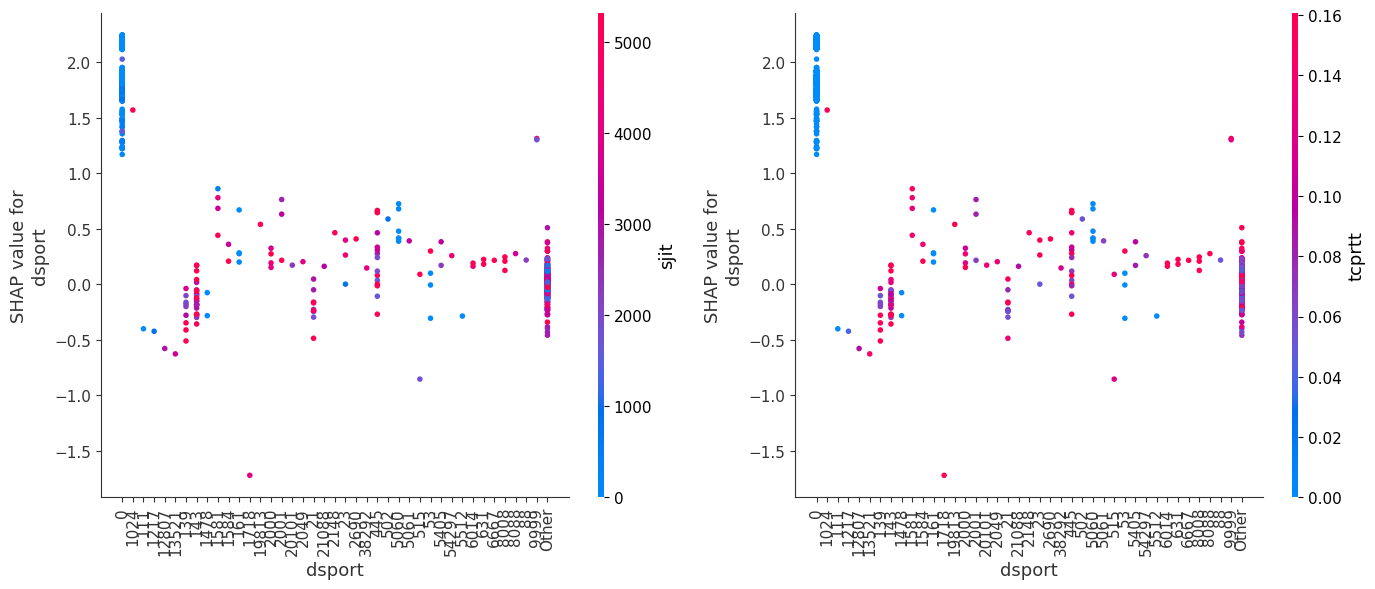

In [41]:
sm1.plot_dependence('dsport', n_interaction=2)
sm2.plot_dependence('dsport', n_interaction=2)

We see some interesting differences for sttl. There seem to be only 1 value corresponding to 0 sttl in correct predictions whereas there are many that correspond to incorrect predictions. Correct predictions show some low importance for sttl values of around 60 whereas incorrect predictions consider all these important. The same pattern can be seen for values just above 250. Interestingly we see the same interaction values as before.

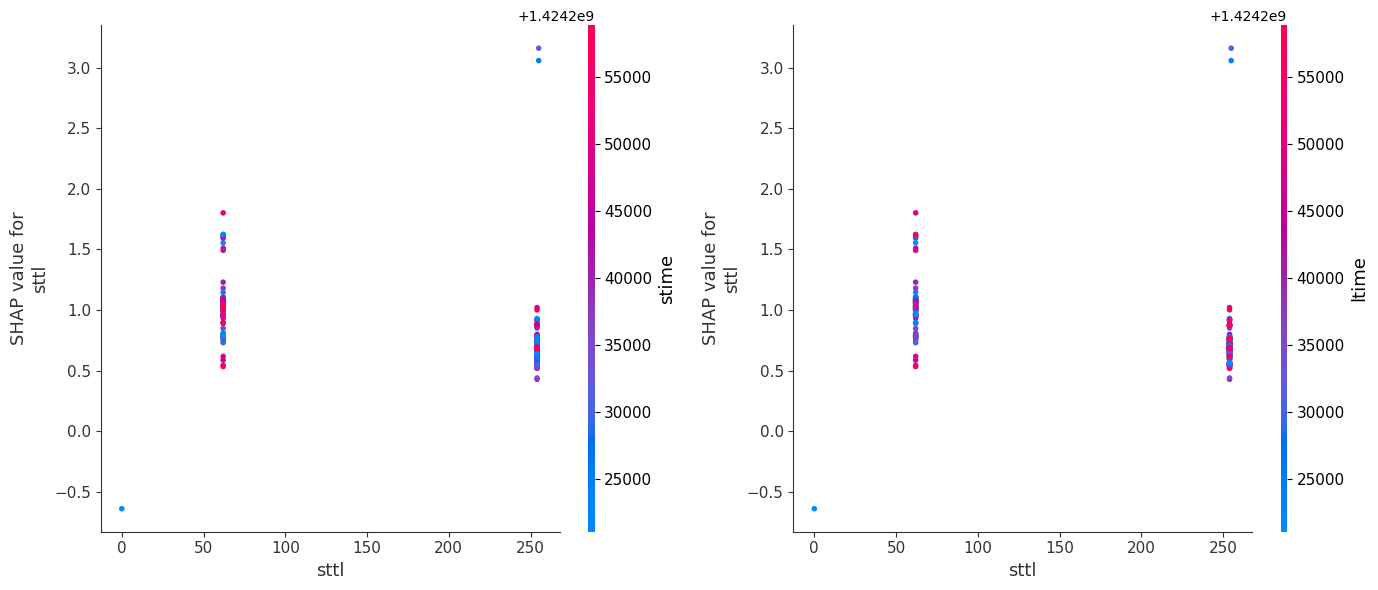

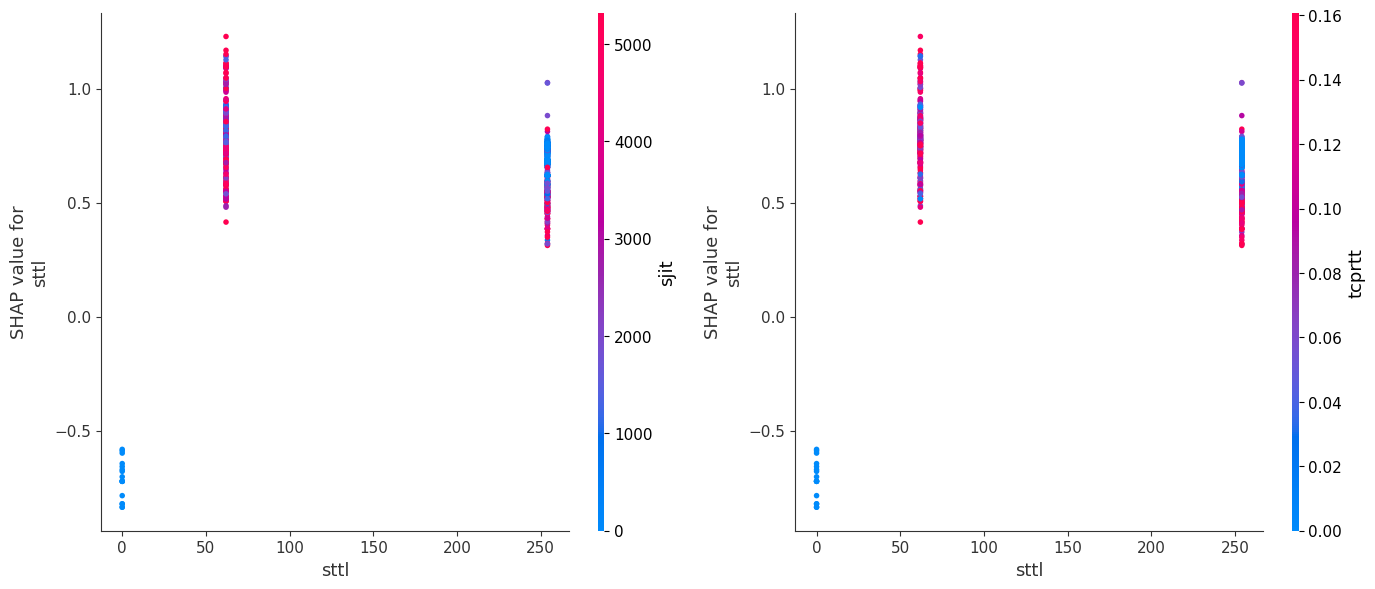

In [42]:
sm1.plot_dependence('sttl', n_interaction=2)
sm2.plot_dependence('sttl', n_interaction=2)

dttl shows no significant differences between correct and incorrect predictions and also finds the same interactions.

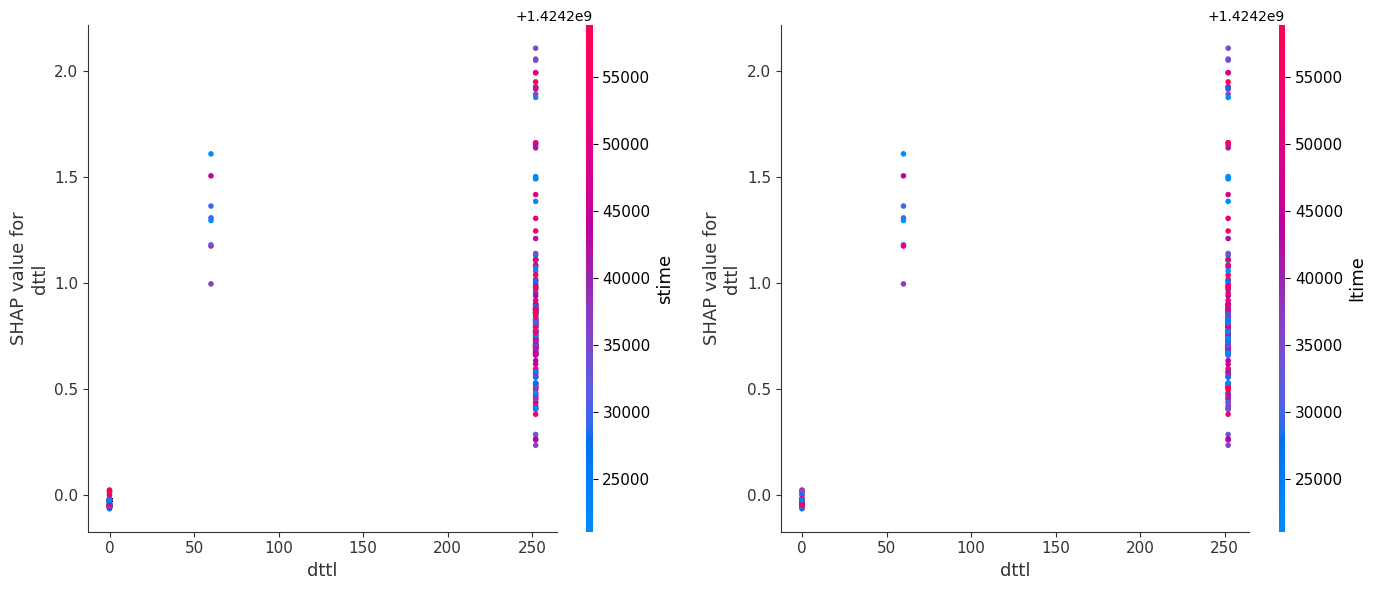

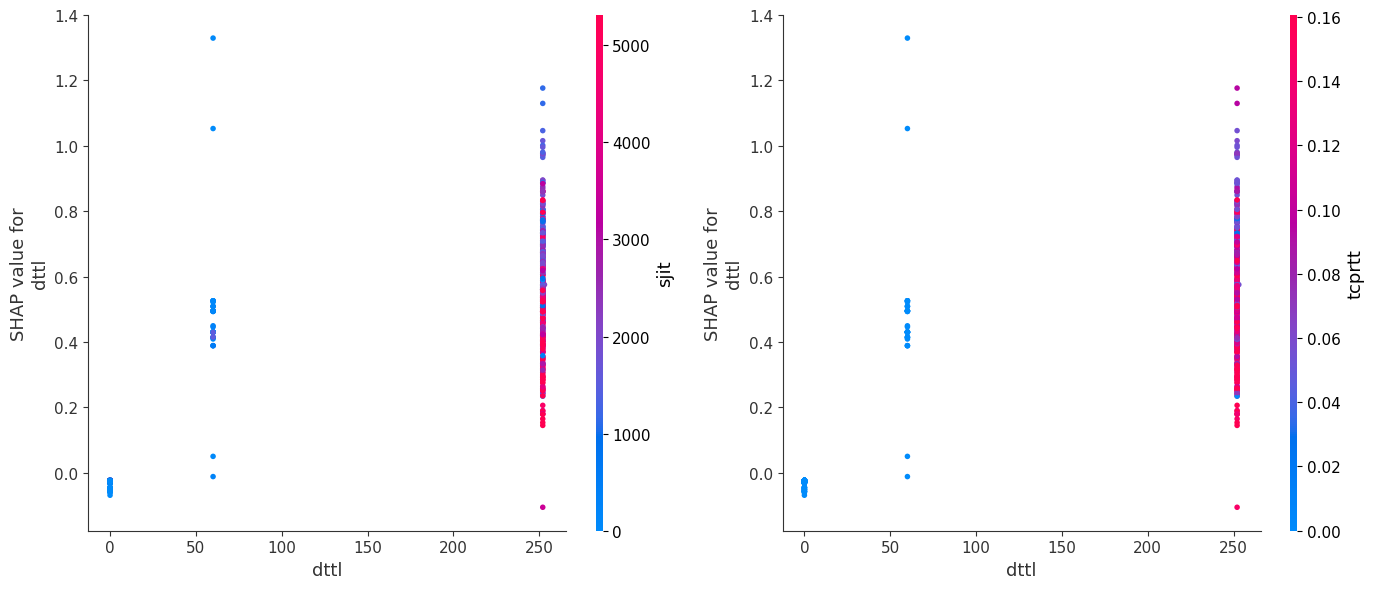

In [43]:
sm1.plot_dependence('dttl', n_interaction=2)
sm2.plot_dependence('dttl', n_interaction=2)

sintpkt seems mostly similar for incorrect and correct predictions except that incorrect predictions shows more values in 0 sintpkts that contribute highly to the incorrect predictions. Again we see the same interactions, stime and ltime don't show any significant patterns between high and low values but for incorrect predictions sjit and tcprtt show high values in low feature importance and low values for high feature importance. 

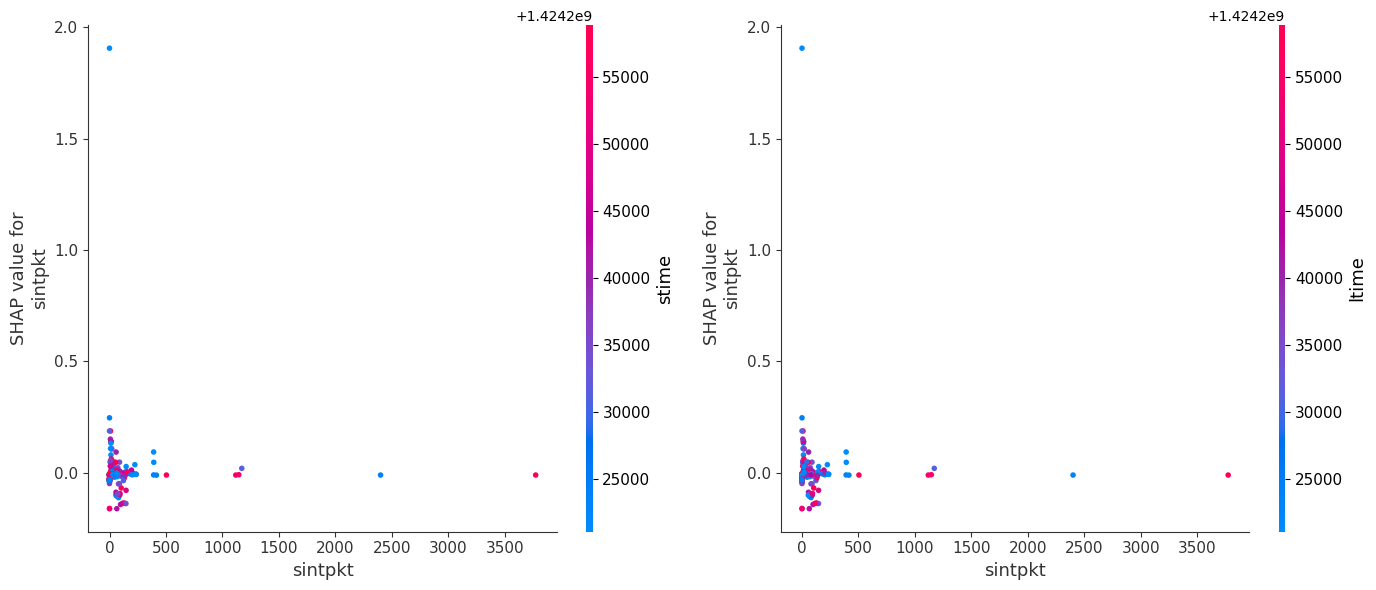

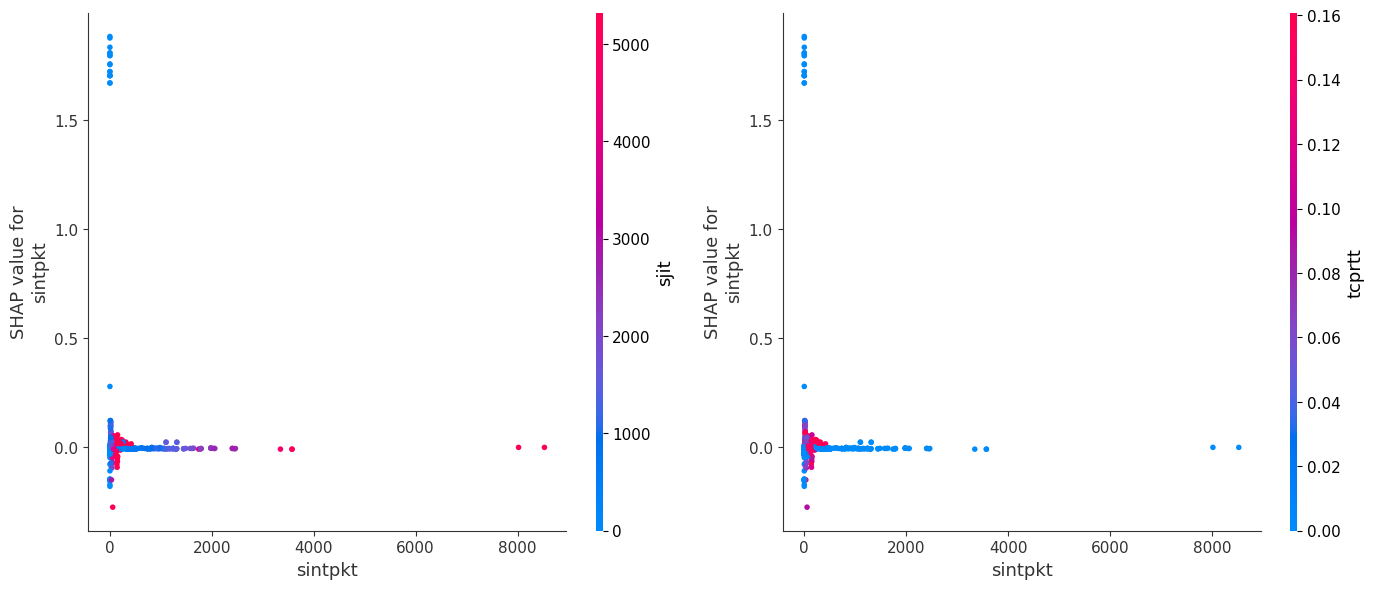

In [44]:
sm1.plot_dependence('sintpkt', n_interaction=2)
sm2.plot_dependence('sintpkt', n_interaction=2)

In [ ]:
type_of = 'label-encoded'
limit = 40
calculation = 'average'
sm1.custom_group('service', limit=limit, calculation=calculation)
sm2.custom_group('service', limit=limit, calculation=calculation)

Some differences found in Service are that more values are found for DNS in correct predictions compared to incorrect predictions but they show almost equal importaance. Other differences are found in POP3 and SMTP where incorrect predictions have a lot more values compared to incorrect predictions that contribute positively to predicting labels. In general most Services are found to contribute positively to label predictions. The interaction indexes are once again the same.

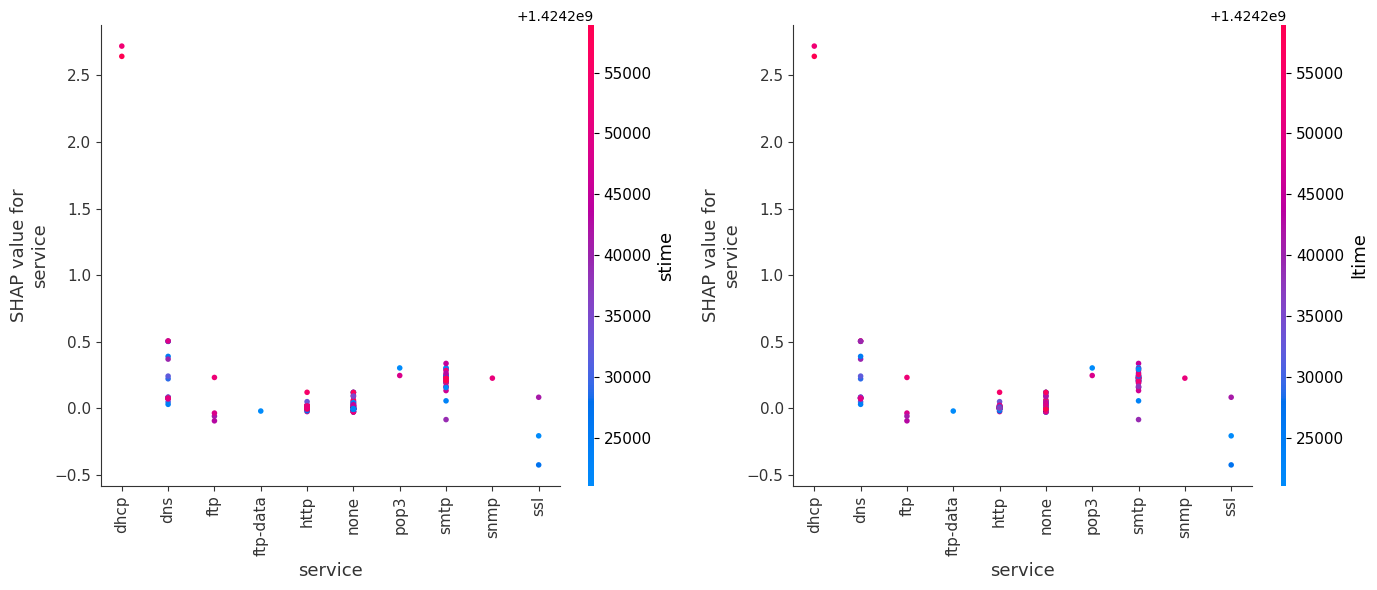

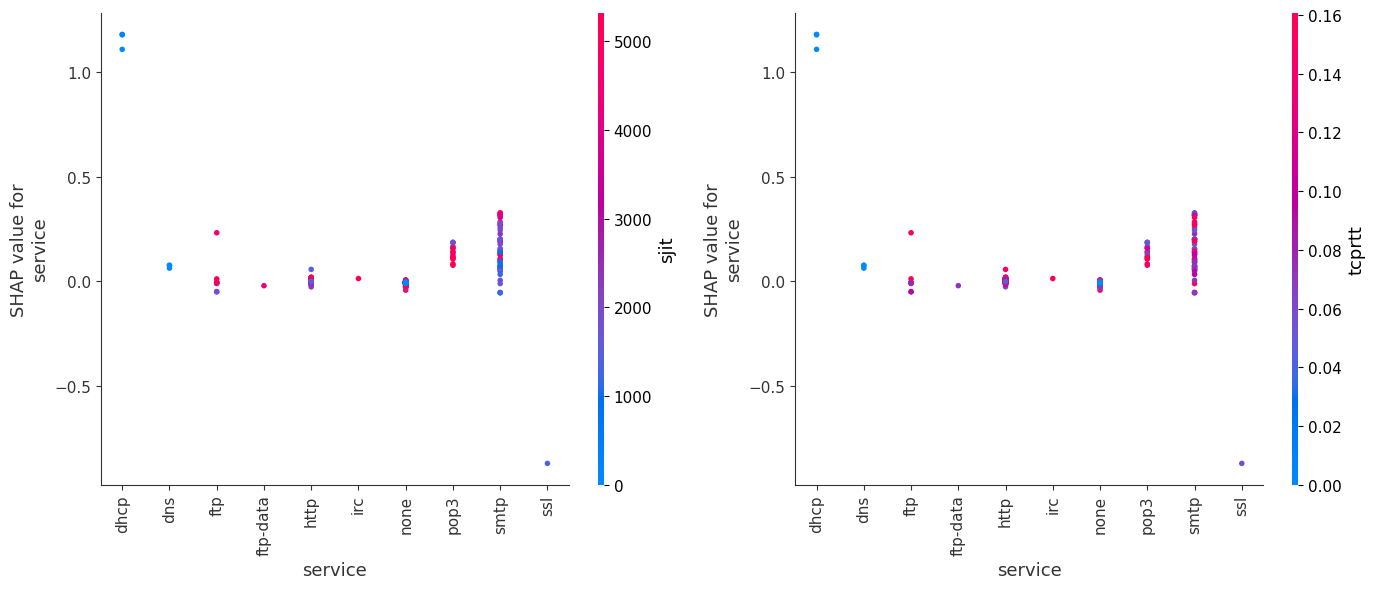

In [45]:
sm1.plot_dependence('service', n_interaction=2)
sm2.plot_dependence('service', n_interaction=2)

In [46]:
type_of = 'label-encoded'
limit = 40
calculation = 'average'
sm1.custom_group('state', limit=limit, calculation=calculation)
sm2.custom_group('state', limit=limit, calculation=calculation)

There seem to be no significant differences in State for correct and incorrect labels except for CON where we see a lot more values that have high importance in correct predictions. As for incorrect predictions CON seems to have low importance. This might be the reason we see this difference in the previous summary plots.

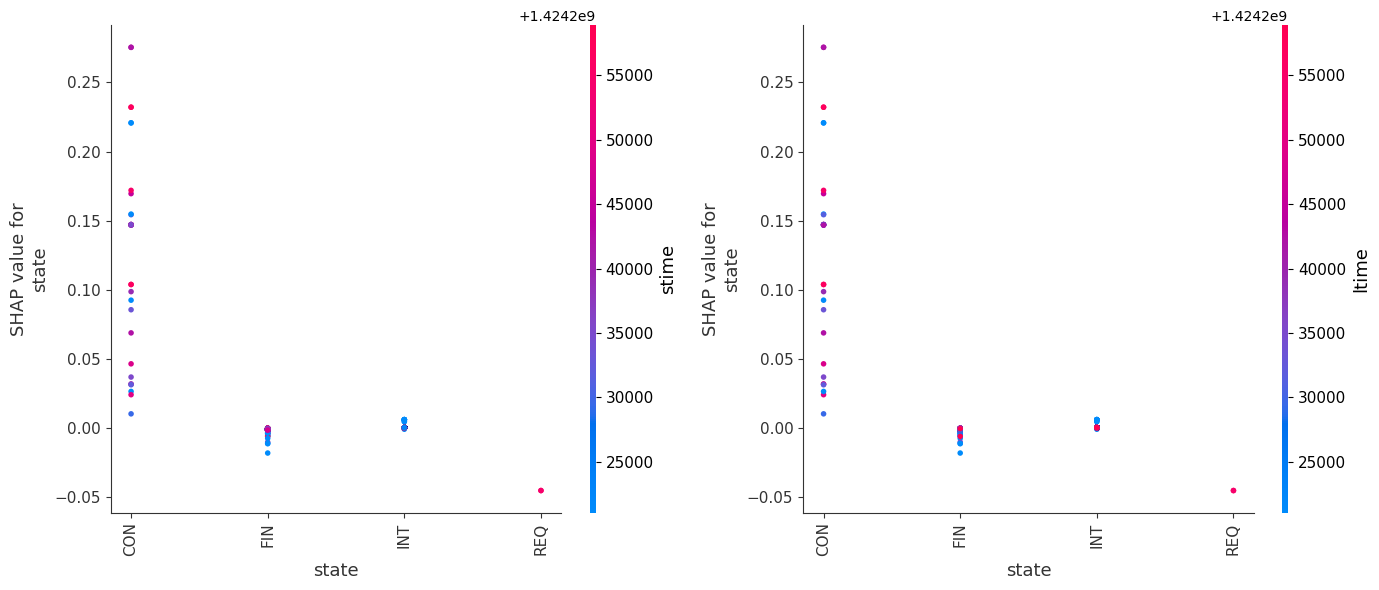

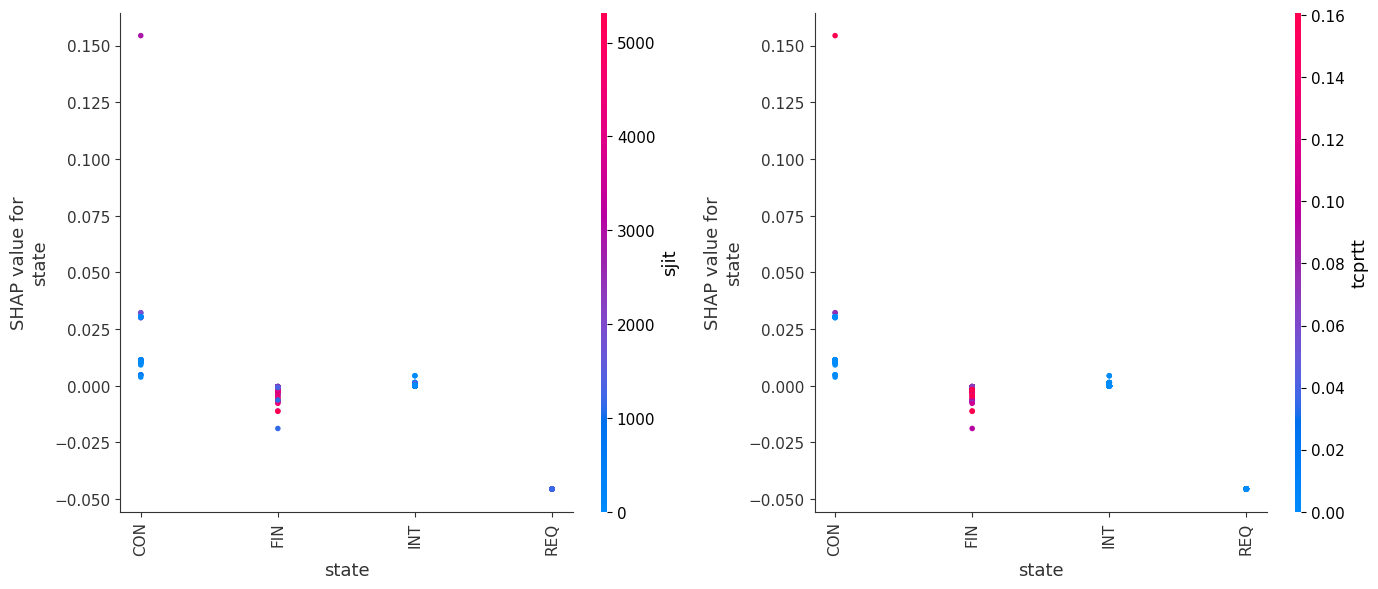

In [48]:
sm1.plot_dependence('state', n_interaction=2)
sm2.plot_dependence('state', n_interaction=2)

In [49]:
type_of = 'label-encoded'
limit = 40
calculation = 'average'
sm1.custom_group('proto', limit=limit, calculation=calculation)
sm2.custom_group('proto', limit=limit, calculation=calculation)

The grouping calculation has picked up different Protocols that are importanct for correct and incorrect predictions. For correct predictions the most important are UDP, X-Net, XNES-IDP, XTP, and ZERO. For incorrect predictions the most important Protocols are Mobile, SCTP, VRRP. The incorrect predictions also seem to have alot more Protocols that have low importance compared to the correct predictions.

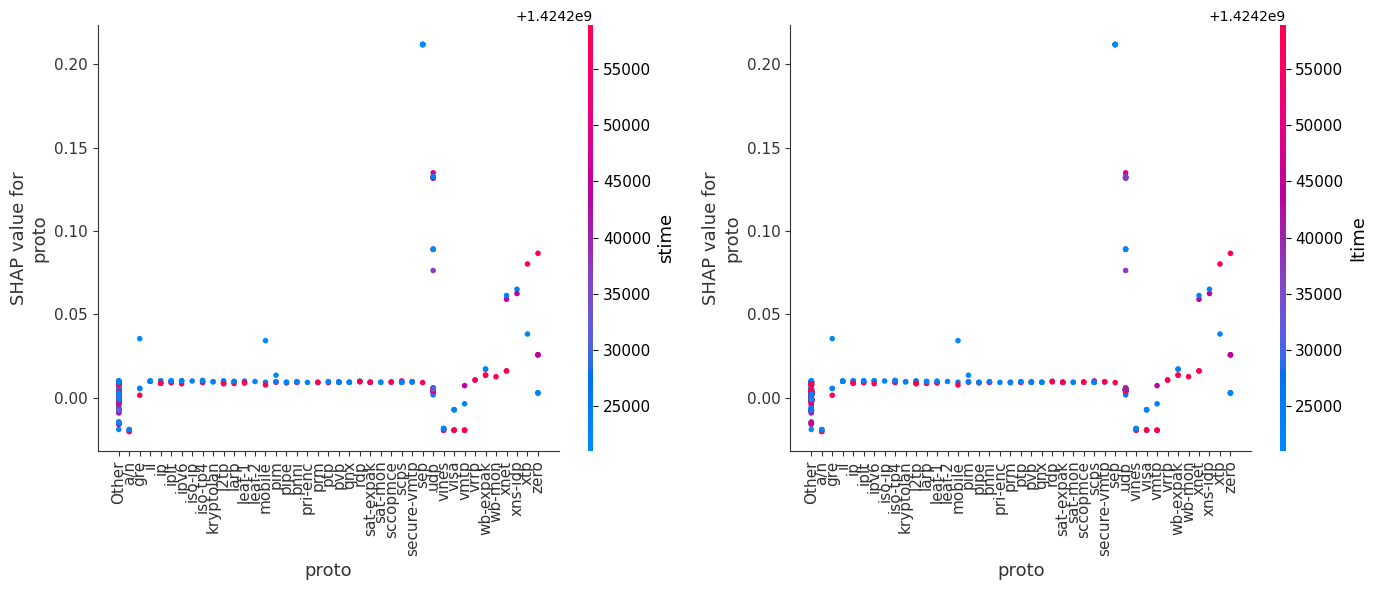

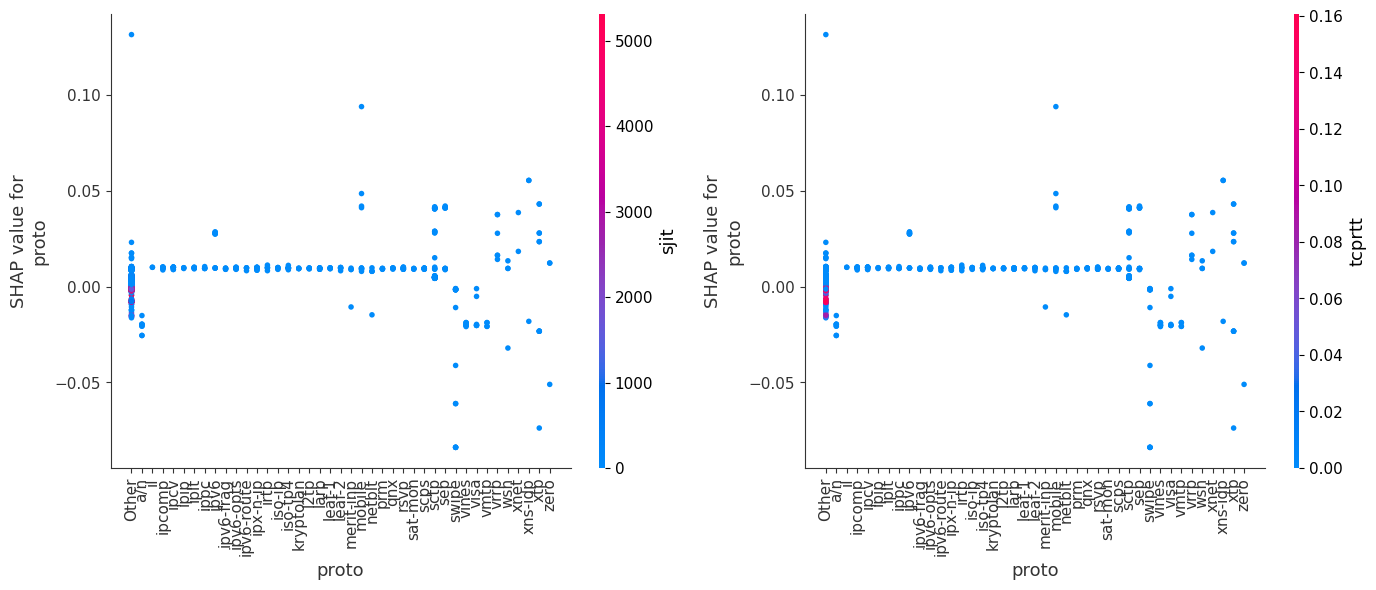

In [50]:
sm1.plot_dependence('proto', n_interaction=2)
sm2.plot_dependence('proto', n_interaction=2)

In conclusion we find thaat the interactions seem to be consistently the same for all the features that showed high importance in the summary plots with stime and ltime for correct predictions and sjit and tcprtt for incorrect predictions. The biggest differences seem to be in Source and Destination Ports especially Port 0. Sttl showed some differences and so did state for CON. We see a large difference in what the grouping function picks up for Protocols along with different levels of feature importance. As for the dttl and sintpkt, they seem to be quite similar comparatively. 
